**1.0 Carregando dataset**

In [ ]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [ ]:
import pandas as pd
dataSemStopWords = pd.read_csv('../../datasets/dataSemStopWords.csv', engine='python')


**2.0 Estamos com um Problema! (Positivo vs. Negativo)**

* Como ja visto, o dataset que pré-processei anteriormente contém a regra de negócio completa, com as três classes de sentimento: positivo, neutro e negativo. No entanto, o objetivo deste notebook específico é treinar um modelo BERT focado em uma análise de sentimento bipolar, ou seja, capaz de diferenciar apenas comentários claramente positivos dos negativos.

* Para garantir que o modelo aprenda os padrões distintivos dessas duas classes sem a interferência ou o "ruído" dos comentários neutros, irei removê-los completamente. Essa simplificação do problema permite que o modelo se especialize em sua tarefa, potencializando sua performance na distinção dos dois polos de sentimento.

* O código a seguir executa essa filtragem, excluindo todas as avaliações com nota 3. Adicionalmente, ele converte a coluna de texto para o tipo string para garantir a compatibilidade com as ferramentas de modelagem.

In [ ]:
dataSemStopWords['feedback'] = dataSemStopWords.apply(lambda x: 1 if x['rating'] >= 3 else 0, axis=1)


In [ ]:
dataSemStopWords = dataSemStopWords[dataSemStopWords['rating'] != 3]

In [ ]:
dataSemStopWords['texto_lematizado'] = dataSemStopWords['texto_lematizado'].astype(str)


<ipython-input-6-011c9478832a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSemStopWords['texto_lematizado'] = dataSemStopWords['texto_lematizado'].astype(str)


In [ ]:
dataSemStopWords

,review_text,rating,feedback,texto_lematizado
0,bem macio felpudo recomendo preço imbatível en...,4,1,bem macio felpudo recomendo preço imbatível en...
1,produto excepcional recomendo inovador gostoso...,5,1,produto excepcional recomendo inovador gostoso...
2,recebi produto antes prazo veio defeito trava ...,1,0,recebi produto antes prazo vir defeito trar us...
3,bom custo beneficio adequado pessoas fazem uso...,5,1,bom custo beneficio adequado pessoa fazer uso ...
5,ótmo produto atendeu expectativas entrega ocor...,4,1,ótmo produto atender expectativa entregar ocor...
...,...,...,...,...
132367,ótimo jogo melhores joguei entrega produto loj...,5,1,bom jogo bom joguei entregar produto lojar ant...
132368,smarthphone perfeito bom economia energia perf...,5,1,smarthphone perfeito bom economia energia perf...
132369,chateado gostaria vcs resolve rápido pq pagand...,1,0,chatear gostar vcs resolver rápido pq pagar co...
132371,produto anunciado site dizia algodão porém rec...,1,0,produto anunciar site dizer algodão porém rece...


In [ ]:
pip install tensorflow

**3.0 Tokenização!!**

* Para manter o modelo eficiente e focado, limitei o vocabulário às 15.000 palavras mais comuns, e qualquer palavra fora desse conjunto será tratada como um token desconhecido (<unk>). Após a tokenização, cada avaliação se torna uma sequência de números, mas com comprimentos diferentes, além de um padding de 150 token por avaliação.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Instanciar e configurar o tokenizador
tokenizer = Tokenizer(num_words=15000, oov_token="<unk>")  # Limitar o vocabulário aos 15000 termos mais frequentes

# 2. Ajustar o tokenizador aos seus textos (coluna texto_lematizado)
tokenizer.fit_on_texts(dataSemStopWords['texto_lematizado'])

# 3. Converter os textos em sequências de inteiros
sequences = tokenizer.texts_to_sequences(dataSemStopWords['texto_lematizado'])

# 4. Padronizar o tamanho das sequências (opcional, mas recomendado)
max_length = 150  # Tamanho máximo da sequência (ajuste conforme necessidade)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# 5. Visualizar o resultado
print(f"Tamanho do vocabulário: {len(tokenizer.word_index)}")
print(f"Forma do array de sequências: {padded_sequences.shape}")
print(f"Exemplo de sequência original: {sequences[0][:20]}...")
print(f"Exemplo de sequência padronizada: {padded_sequences[0][:20]}...")


Tamanho do vocabulário: 39900
Forma do array de sequências: (116058, 150)
Exemplo de sequência original: [8, 460, 3567, 16, 40, 3016, 58, 13, 1324, 28, 135]...
Exemplo de sequência padronizada: [   8  460 3567   16   40 3016   58   13 1324   28  135    0    0    0
    0    0    0    0    0    0]...


**3.1 Divisão Estratificada: Treino, Validação e Teste**

* Utilizarei uma separação em três partes: 80% para treino, 10% para validação (ajuste de hiperparâmetros) e 10% para teste (avaliação final e imparcial).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Passo 1: Primeira Divisão (Treino / Resto) ---
train_df, temp_df = train_test_split(
    dataSemStopWords,
    test_size=0.2,
    random_state=42,
    stratify=dataSemStopWords['feedback']
)

# --- Passo 2: Segunda Divisão (Validação / Teste) ---
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['feedback'] # Estratificar aqui também é importante
)

print(dataSemStopWords)
print(train_df)
print(val_df)
print(test_df)


                                              review_text  rating  feedback  \
0       bem macio felpudo recomendo preço imbatível en...       4         1   
1       produto excepcional recomendo inovador gostoso...       5         1   
2       recebi produto antes prazo veio defeito trava ...       1         0   
3       bom custo beneficio adequado pessoas fazem uso...       5         1   
5       ótmo produto atendeu expectativas entrega ocor...       4         1   
...                                                   ...     ...       ...   
132367  ótimo jogo melhores joguei entrega produto loj...       5         1   
132368  smarthphone perfeito bom economia energia perf...       5         1   
132369  chateado gostaria vcs resolve rápido pq pagand...       1         0   
132371  produto anunciado site dizia algodão porém rec...       1         0   
132372  recebi produto consta entregue site reclamei v...       1         0   

                                         texto_lema

In [ ]:
# ==============================================================================
# 1. IMPORTS CORRETOS
# ==============================================================================
from transformers import AutoTokenizer, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import os # Para gerenciar caminhos de arquivo

# ==============================================================================
# 2. CARREGAR MODELO E TOKENIZER (BERTIMBAU)
# ==============================================================================

# ==============================================================================
# 3. PREPARAR DADOS (com a coluna 'texto_lematizado' e 'feedback')
# ==============================================================================


# ==============================================================================
# 4. CÁLCULO DOS PESOS DE CLASSE (CLASS WEIGHTS)
# ==============================================================================

# ==============================================================================
# 5. CONFIGURAR HIPERPARÂMETROS E OTIMIZADOR COMPATÍVEL
# ==============================================================================


# ==============================================================================
# 6. COMPILAR O MODELO
# ==============================================================================



# ==============================================================================
# 8. TREINAR O MODELO COM LOOP MANUAL (CALLBACKS MANUAIS)
# ==============================================================================




**Bertimbau!**

In [ ]:
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Preparando dados**
* Para preparar os dados, vou usar o tokenizer para converter cada avaliação em input IDs e attention masks, padronizando o comprimento em 150 tokens. Em seguida, encapsularei esses dados tokenizados junto com seus respectivos rótulos em objetos tf.data.Dataset, criando um pipeline de dados otimizado e de alta performance para o treinamento no TensorFlow.

In [ ]:
train_encodings = tokenizer(train_df['texto_lematizado'].tolist(), truncation=True, padding=True, max_length=150, return_tensors='tf')
val_encodings = tokenizer(val_df['texto_lematizado'].tolist(), truncation=True, padding=True, max_length=150, return_tensors='tf')
test_encodings = tokenizer(test_df['texto_lematizado'].tolist(), truncation=True, padding=True, max_length=150, return_tensors='tf')

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_df['feedback'].values))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_df['feedback'].values))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_df['feedback'].values))


**Class Weights para o desbalanceamento dos dados**

In [ ]:
y_train_labels = train_df['feedback'].values
class_labels = np.unique(y_train_labels)
class_weights_array = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_labels)
class_weight_dict = dict(zip(class_labels, class_weights_array))


print(f"Classes: {class_labels}")
print(f"Pesos das Classes Calculados: {class_weights_array}")
print(f"Dicionário de Pesos para Keras: {class_weight_dict}")


Classes: [0 1]
Pesos das Classes Calculados: [1.62284136 0.72264944]
Dicionário de Pesos para Keras: {np.int64(0): np.float64(1.622841361952038), np.int64(1): np.float64(0.7226494396014944)}


**HiperParametros**
* Com os dados prontos, agora vou configurar os parametros para a modelagem. Irei configurar o batch_size como 16, que define quantos exemplos o modelo verá antes de atualizar seus pesos. O número de epochs será 2, o que significa que o modelo irá percorrer todo o conjunto de dados de treino duas vezes, além do learning rate scheduler com warmup.


In [ ]:
batch_size = 16
epochs = 2 # Número máximo de epochs

train_batches = train_dataset.shuffle(len(train_df)).batch(batch_size)
val_batches = val_dataset.batch(batch_size)
test_batches = test_dataset.batch(batch_size)

steps_per_epoch = len(train_df) // batch_size
if len(train_df) % batch_size != 0:
    steps_per_epoch += 1
total_train_steps = steps_per_epoch * epochs

optimizer, lr_schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=total_train_steps,
    num_warmup_steps=int(0.1 * total_train_steps),
    weight_decay_rate=0.01
)

**Compilando o modelo!!**

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

**Treinando**

In [ ]:
print("Iniciando o treinamento do BERTimbau com class_weight e callbacks manuais...")

history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=epochs, # Agora treina todas as 'epochs' de uma vez
    class_weight=class_weight_dict,
    # steps_per_epoch=steps_per_epoch, # Geralmente não é necessário se train_batches tem tamanho definido
    verbose=1
)
print("Treinamento concluído!")

Iniciando o treinamento do BERTimbau com class_weight e callbacks manuais...
Epoch 1/2
5803/5803 [==============================] - 2994s 512ms/step - loss: 0.1812 - accuracy: 0.9283 - val_loss: 0.1400 - val_accuracy: 0.9458
Epoch 2/2
5803/5803 [==============================] - 2975s 513ms/step - loss: 0.1026 - accuracy: 0.9637 - val_loss: 0.1421 - val_accuracy: 0.9486
Treinamento concluído!


**Resultados e Métricas**


--- Avaliação no Conjunto de Teste (com melhores pesos carregados manualmente) ---
726/726 [==============================] - 126s 174ms/step - loss: 0.1325 - accuracy: 0.9539
Loss no Teste: 0.1325
Acurácia no Teste: 95.39%
726/726 [==============================] - 124s 171ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.92      0.93      0.93      3576
    Positivo       0.97      0.97      0.97      8030

    accuracy                           0.95     11606
   macro avg       0.95      0.95      0.95     11606
weighted avg       0.95      0.95      0.95     11606



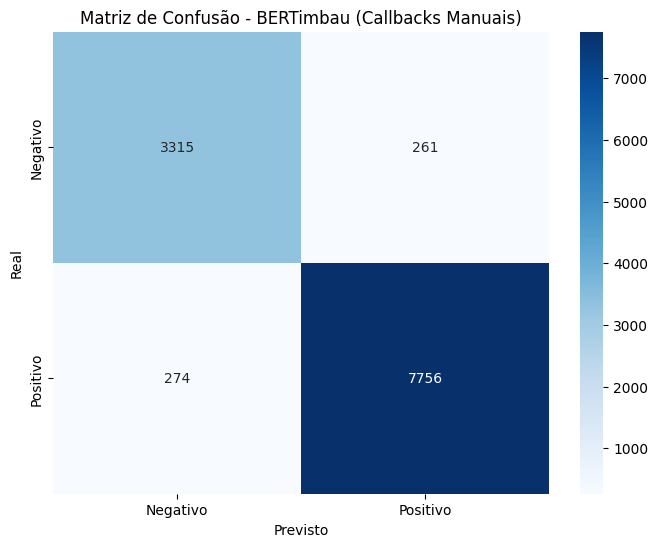

In [ ]:
print("\n--- Avaliação no Conjunto de Teste (com melhores pesos carregados manualmente) ---")

# CORRETO: Use test_batches para avaliar
result = model.evaluate(test_batches)
print(f"Loss no Teste: {result[0]:.4f}")
print(f"Acurácia no Teste: {result[1] * 100:.2f}%")


# CORRETO: Use test_batches para fazer predições
preds = model.predict(test_batches)
pred_classes = np.argmax(preds.logits, axis=1)


# Gerar relatório de classificação
print("\nRelatório de Classificação:")
# ATENÇÃO AQUI TAMBÉM: target_names deve corresponder às suas 3 classes
print(classification_report(
    list(test_df['feedback'].values), # Seus rótulos verdadeiros do conjunto de teste
    pred_classes,                   # Suas classes preditas
    target_names=['Negativo', 'Positivo']
))

# Matriz de confusão
cm = confusion_matrix(list(test_df['feedback'].values), pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo',  'Positivo'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão - BERTimbau (Callbacks Manuais)')
plt.show()